In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
# Patient file paths
patients = {
    1: ['Data/organized_fcs_data1a.csv', 'Data/organized_fcs_data1b.csv', 'Data/organized_fcs_data1c.csv'],
    2: ['Data/organized_fcs_data2a.csv', 'Data/organized_fcs_data2b.csv', 'Data/organized_fcs_data2c.csv'],
    3: ['Data/organized_fcs_data3a.csv', 'Data/organized_fcs_data3b.csv', 'Data/organized_fcs_data3c.csv'],
    4: ['Data/organized_fcs_data4a.csv', 'Data/organized_fcs_data4b.csv', 'Data/organized_fcs_data4c.csv'],
    5: ['Data/organized_fcs_data5a.csv', 'Data/organized_fcs_data5b.csv', 'Data/organized_fcs_data5c.csv'],
    6: ['Data/organized_fcs_data6a.csv', 'Data/organized_fcs_data6b.csv', 'Data/organized_fcs_data6c.csv'],
    7: ['Data/organized_fcs_data7.csv'],
    8: ['Data/organized_fcs_data8a.csv', 'Data/organized_fcs_data8b.csv', 'Data/organized_fcs_data8c.csv'],
    9: ['Data/organized_fcs_data9a.csv', 'Data/organized_fcs_data9b.csv'],
    10: ['Data/organized_fcs_data10a.csv', 'Data/organized_fcs_data10b.csv', 'Data/organized_fcs_data10c.csv'],
    11: ['Data/organized_fcs_data11.csv'],
    12: ['Data/organized_fcs_data12a.csv', 'Data/organized_fcs_data12b.csv', 'Data/organized_fcs_data12c.csv'],
    13: ['Data/Case_13a.csv', 'Data/Case_13b.csv', 'Data/Case_13c.csv'],
    14: ['Data/Case_14a.csv', 'Data/Case_14b.csv', 'Data/Case_14c.csv'],
    15: ['Data/Case_15a.csv', 'Data/Case_15b.csv', 'Data/Case_15c.csv'],
    16: ['Data/Case_16a.csv', 'Data/Case_16b.csv', 'Data/Case_16c.csv'],
    17: ['Data/Case_17a.csv', 'Data/Case_17b.csv', 'Data/Case_17c.csv'],
    18: ['Data/Case_18.csv']
}

In [5]:
def load_patient_data(patient_ids):
    all_data = []
    for pid in patient_ids:
        for file in patients[pid]:
            if os.path.exists(file):
                df = pd.read_csv(file)
                if 'Time' in df.columns:
                    df = df.drop(columns=['Time'])
                all_data.append(df.astype(np.float32).values)
            else:
                print(f"File not found: {file}")
    if all_data:
        return np.vstack(all_data)
    else:
        return np.empty((0, 19))  



In [6]:
# Load healthy and unhealthy data
healthy_cells = load_patient_data([1, 2, 3, 4, 5, 6])
unhealthy_cells = load_patient_data([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [7]:
# Scaling data
print("Scaling data")
scaler = StandardScaler()
healthy_cells_scaled = scaler.fit_transform(healthy_cells)
unhealthy_cells_scaled = scaler.transform(unhealthy_cells)

Scaling data


In [6]:
# Fitting GMM to scaled healthy cells
print("Fitting GMM to healthy data")
gmm = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
gmm.fit(healthy_cells_scaled)

Fitting GMM to healthy data


GaussianMixture(covariance_type='tied', n_components=4, random_state=42)

In [8]:
# Saving model
# joblib.dump(gmm, 'gmm_s_complete_tied_4.pkl')
# print("GMM model saved")

gmm = joblib.load('gmm_s_complete_tied_4.pkl')

In [9]:
# Score both healthy & unhealthy cells
print("Scoring cells")
healthy_scores = gmm.score_samples(healthy_cells_scaled)
unhealthy_scores = gmm.score_samples(unhealthy_cells_scaled)

Scoring cells


In [10]:
threshold1 = np.percentile(healthy_scores, 1) 
print(threshold1)

threshold2 = np.percentile(healthy_scores, 1.5) 
print(threshold2)

-47.07633564244437
-42.01335582812797


In [11]:
# Detecting anomalies in unhealthy cells
anomalies = unhealthy_scores < threshold2
healthy_anomalies = healthy_scores < threshold2

In [12]:
#Each patient MRD percentages:
print("\n MRD percentage for each unhealthy patient:")

unhealthy_patient_ids = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
start_idx = 0

for pid in unhealthy_patient_ids:
    patient_data = load_patient_data([pid])
    patient_cells = len(patient_data)
    patient_anomalies = anomalies[start_idx:start_idx + patient_cells]
    patient_mrd_percentage = (np.sum(patient_anomalies) / patient_cells) * 100
    print(f"Patient {pid}: {patient_mrd_percentage:.4f}% MRD")
    start_idx += patient_cells


 MRD percentage for each unhealthy patient:
Patient 7: 4.8857% MRD
Patient 8: 2.2365% MRD
Patient 9: 9.8760% MRD
Patient 10: 3.5880% MRD
Patient 11: 14.5399% MRD
Patient 12: 4.5366% MRD
Patient 13: 3.6923% MRD
Patient 14: 2.0531% MRD
Patient 15: 1.1314% MRD
Patient 16: 3.4595% MRD
Patient 17: 0.8954% MRD
Patient 18: 7.1589% MRD


In [ ]:
# MRD% in new patients

# Patient 13: 3.6923% MRD
# Patient 14: 2.0531% MRD
# Patient 15: 1.1314% MRD
# Patient 16: 3.4595% MRD
# Patient 17: 0.8954% MRD
# Patient 18: 7.1589% MRD

In [12]:
print("\nMRD percentage for each healthy patient (using precomputed anomalies):")

healthy_patient_ids = [1, 2, 3, 4, 5, 6]
start_idx = 0

for pid in healthy_patient_ids:
    patient_data = load_patient_data([pid])
    patient_cells = len(patient_data)
    
    # Use precomputed anomalies
    patient_anomalies = healthy_anomalies[start_idx:start_idx + patient_cells]
    patient_mrd_percentage = (np.sum(patient_anomalies) / patient_cells) * 100
    
    print(f"Patient {pid}: {patient_mrd_percentage:.4f}% MRD")
    
    start_idx += patient_cells



MRD percentage for each healthy patient (using precomputed anomalies):
Patient 1: 1.5117% MRD
Patient 2: 1.2537% MRD
Patient 3: 0.7935% MRD
Patient 4: 1.2044% MRD
Patient 5: 0.3991% MRD
Patient 6: 0.9407% MRD


In [ ]:
# MRD% in new patients

# Patient 13: 3.6923% MRD
# Patient 14: 2.0531% MRD
# Patient 15: 1.1314% MRD
# Patient 16: 3.4595% MRD
# Patient 17: 0.8954% MRD
# Patient 18: 7.1589% MRD

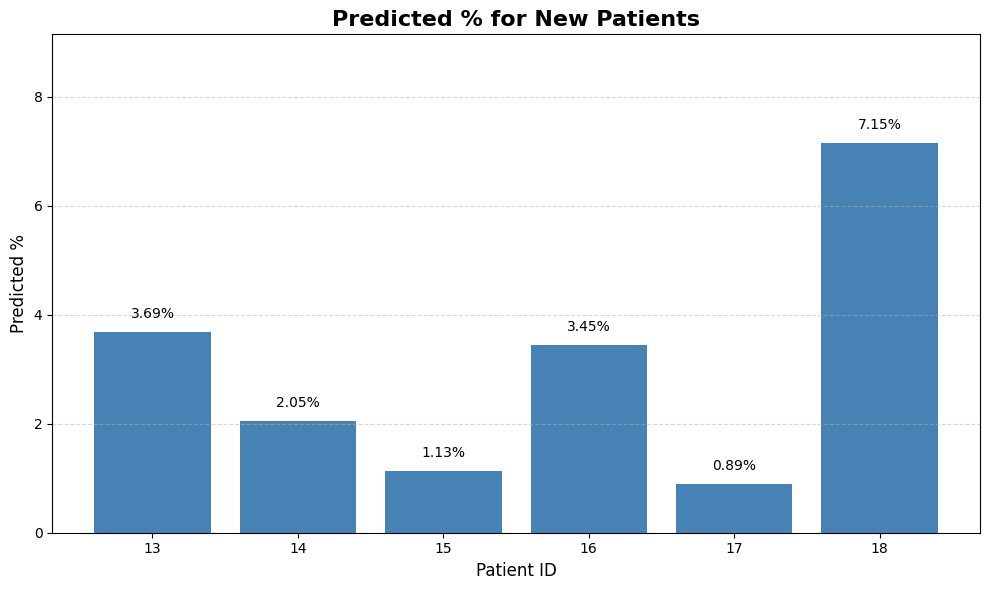

In [1]:
import matplotlib.pyplot as plt

patient_ids = [13, 14, 15, 16, 17, 18]
predicted_percent = [3.69, 2.05, 1.13, 3.45, 0.89, 7.15]

uniform_color = 'steelblue'

plt.figure(figsize=(10, 6))
bars = plt.bar([str(pid) for pid in patient_ids], predicted_percent, color=uniform_color)

for bar, val in zip(bars, predicted_percent):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.2,
             f'{val:.2f}%',
             ha='center',
             va='bottom',
             fontsize=10)

plt.title('Predicted % for New Patients', fontsize=16, fontweight='bold')
plt.xlabel('Patient ID', fontsize=12)
plt.ylabel('Predicted %', fontsize=12)
plt.ylim(0, max(predicted_percent) + 2)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
